# 構造活性相関（QSAR）の基礎

## 効果ありなしの原因を考えてみる（分類問題）

In [1]:
from rdkit import Chem, DataStructs
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import IPythonConsole
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.ensemble import RandomForestClassifier

/Users/kzfm/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/kzfm/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/kzfm/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
mols = []
labels = []
with open("ch09_compounds.txt") as f:
    header = f.readline()
    smiles_index = -1
    for i, title in enumerate(header.split("\t")):
        if title == "CANONICAL_SMILES":
            smiles_index = i
        elif title == "STANDARD_VALUE":
            value_index = i
    for l in f:
        ls = l.split("\t")
        mol = Chem.MolFromSmiles(ls[smiles_index])
        mols.append(mol)
        val = float(ls[value_index])
        if val < 1000:
            labels.append("POS")
        else:
            labels.append("NEG")

In [5]:
labels = np.array(labels)

In [7]:
fps = []
for mol in mols:
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2)
    arr = np.zeros((1,))
    DataStructs.ConvertToNumpyArray(fp, arr)
    fps.append(arr)
fps = np.array(fps)

In [11]:
x_train, x_test, y_train, y_test = train_test_split(fps, labels)

In [12]:
rf = RandomForestClassifier()
rf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [23]:
y_pred = rf.predict(x_test)

In [24]:
confusion_matrix(y_test, y_pred)

array([[11,  1],
       [ 5,  2]])

In [26]:
f1_score(y_test, y_pred, pos_label="POS" )

0.4

   ## 薬の効き目を予測しよう（回帰問題）

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from math import log10

In [35]:
pIC50s = []
with open("ch09_compounds.txt") as f:
    header = f.readline()
    for i, title in enumerate(header.split("\t")):
        if title == "STANDARD_VALUE":
            value_index = i
    for l in f:
        ls = l.split("\t")
        val = float(ls[value_index])
        pIC50 = 9 - log10(val)
        pIC50s.append(pIC50)

pIC50s = np.array(pIC50s)

In [37]:
x_train, x_test, y_train, y_test = train_test_split(fps, pIC50s)

In [38]:
rf = RandomForestRegressor()
rf.fit(x_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [39]:
y_pred = rf.predict(x_test)

In [41]:
r2_score(y_test, y_pred)

0.5213586033887229

### おまけ

In [5]:
from rdkit.Chem import rdDepictor
from rdkit.Chem import rdFMCS
from rdkit.Chem import TemplateAlign

In [13]:
est = Chem.MolFromSmiles("C[C@]12CC[C@H]3[C@@H](CCc4cc(O)ccc34)[C@@H]1CC[C@@H]2O")
met_est = Chem.MolFromSmiles("C[C@]12CC[C@H]3[C@@H](CCc4cc(OC)ccc34)[C@@H]1CC[C@@H]2O")
est_fp = AllChem.GetMorganFingerprint(est, 2)
met_est_fp = AllChem.GetMorganFingerprint(met_est, 2)
sim = DataStructs.TanimotoSimilarity(met_est_fp, est_fp)
print(sim)

0.7727272727272727


In [14]:
rdDepictor.Compute2DCoords(est)
rdDepictor.Compute2DCoords(met_est)
res = rdFMCS.FindMCS([est, met_est], completeRingsOnly=True, atomCompare=rdFMCS.AtomCompare.CompareAny)

In [15]:
MCS = Chem.MolFromSmarts(res.smartsString)
rdDepictor.Compute2DCoords(MCS)
TemplateAlign.AlignMolToTemplate2D(est, MCS)
TemplateAlign.AlignMolToTemplate2D(met_est, MCS)

1

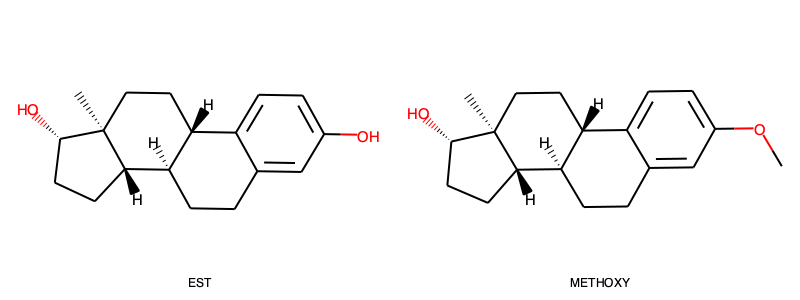

In [16]:
Draw.MolsToGridImage([est, met_est], legends=['EST', 'METHOXY'],subImgSize=(400, 300), molsPerRow=2)